# Image Detection

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Undetectable Barcode

No matching prediction for ground truth barcode with bounding box: [63, 68, 218, 214]
Decoding Accuracy: 0.00%
Predictions: []
Ground Truth: [{'class': 'Barcode', 'confidence': 0.8788421154022217, 'bbox': [63, 68, 218, 214]}]


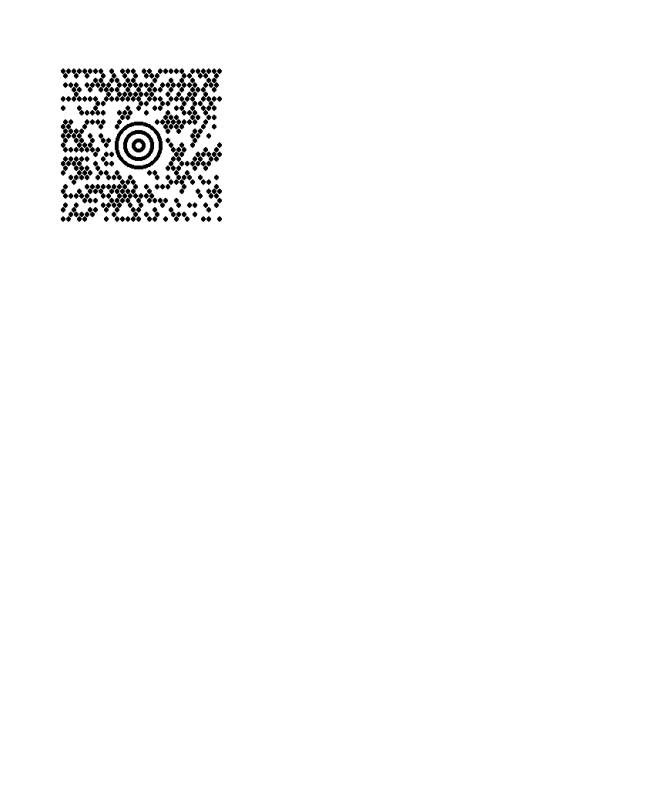

In [ ]:
# Import libraries
import cv2
import json
from pyzbar.pyzbar import decode
import os

image_path = '/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/ZPL Images/5.bmp'
json_path = '/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/output/5_detections.json'

# Load ground truth data from JSON file
def load_ground_truth(json_path):
    with open(json_path, 'r') as file:
        ground_truth_data = json.load(file)
    return ground_truth_data

ground_truth_data = load_ground_truth(json_path)

# Load the BMP image
image = cv2.imread(image_path)
if image is None:
    print(f"Image not found at {image_path}")

# Detect barcodes in the image
predictions = []
barcodes = decode(image)
for barcode in barcodes:
    # Extract bounding box coordinates and decoded data
    x, y, w, h = barcode.rect.left, barcode.rect.top, barcode.rect.width, barcode.rect.height
    bbox = [x, y, w, h]
    decoded_data = barcode.data.decode('utf-8')
    barcode_type = barcode.type
    predictions.append({"bbox": bbox, "data": decoded_data, "type": "Barcode"})

    # Draw bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # Display the decoded data and type on the image
    text = f"{barcode_type}: {decoded_data}"
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Evaluation function for decoding accuracy
def calculate_iou(boxA, boxB):
    # Calculate IoU between two bounding boxes
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxB[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def evaluate_decoding_accuracy(predictions, ground_truth, iou_threshold=0.5):
    correct_decodes = 0
    total_barcodes = sum(1 for gt in ground_truth if gt['class'] == "Barcode")

    for gt in ground_truth:
        gt_bbox = gt['bbox']
        gt_class = gt['class']  # Ground truth type (e.g., "Barcode")

        # Only evaluate for barcodes, skip other classes
        if gt_class != "Barcode":
            continue

        matched = False

        for pred in predictions:
            pred_bbox = pred['bbox']
            pred_data = pred['data']
            pred_type = pred['type']

            # Check IoU and type match for barcodes
            iou = calculate_iou(gt_bbox, pred_bbox)
            if iou >= iou_threshold and pred_type == "Barcode":
                matched = True
                correct_decodes += 1
                break

        if not matched:
            print(f"No matching prediction for ground truth barcode with bounding box: {gt_bbox}")

    decoding_accuracy = correct_decodes / total_barcodes if total_barcodes > 0 else 0
    return decoding_accuracy

# Evaluate decoding accuracy for this image
decoding_accuracy = evaluate_decoding_accuracy(predictions, ground_truth_data)
print(f"Decoding Accuracy: {decoding_accuracy * 100:.2f}%")

# Print predictions and ground truth for reference
print("Predictions:", predictions)
print("Ground Truth:", ground_truth_data)

# Display the image with decoded barcodes
import matplotlib.pyplot as plt

# Convert image from BGR to RGB format for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


## Detectable Barcode

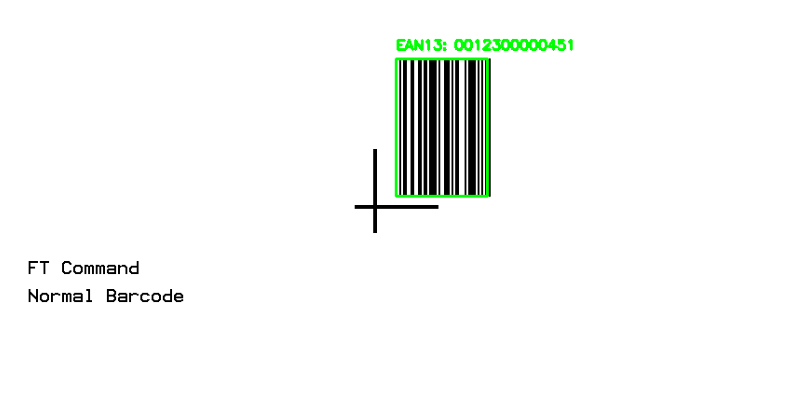

Decoding Accuracy: 100.00%


In [ ]:
# Install the required dependencies
# !apt-get install libzbar0
# !pip install pyzbar

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Import libraries
import cv2
import json
from pyzbar.pyzbar import decode
import os

# Define paths to your image (in BMP format) and JSON file
image_path = '/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/ZPL Images/121.bmp'
json_path = '/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/output/121_detections.json'

# Load ground truth data from JSON file
def load_ground_truth(json_path):
    with open(json_path, 'r') as file:
        ground_truth_data = json.load(file)
    return ground_truth_data

ground_truth_data = load_ground_truth(json_path)

# Load the BMP image
image = cv2.imread(image_path)
if image is None:
    print(f"Image not found at {image_path}")

# Preprocess image for better detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)  # Improve contrast

# Attempt detection with pyzbar
predictions = []
barcodes = decode(gray)
for barcode in barcodes:
    x, y, w, h = barcode.rect.left, barcode.rect.top, barcode.rect.width, barcode.rect.height
    bbox = [x, y, w, h]
    decoded_data = barcode.data.decode('utf-8')
    barcode_type = barcode.type
    predictions.append({"bbox": bbox, "data": decoded_data, "type": "Barcode"})

    # Draw bounding box and display data
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    text = f"{barcode_type}: {decoded_data}"
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Attempt detection with OpenCV QRCodeDetector as a fallback
if not predictions:
    detector = cv2.QRCodeDetector()
    data, bbox, _ = detector.detectAndDecode(gray)

    if data:
        print("OpenCV QRCodeDetector decoded data:", data)
        predictions.append({"bbox": bbox, "data": data, "type": "QR Code"})
        # Draw bounding box from QRCodeDetector
        if bbox is not None:
            for i in range(len(bbox)):
                cv2.line(image, tuple(bbox[i][0]), tuple(bbox[(i + 1) % len(bbox)][0]), (255, 0, 0), 3)

# Display the image with detected barcodes
import matplotlib.pyplot as plt

# Convert image to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

# Evaluate decoding accuracy (if any predictions found)
if predictions:
    decoding_accuracy = evaluate_decoding_accuracy(predictions, ground_truth_data)
    print(f"Decoding Accuracy: {decoding_accuracy * 100:.2f}%")
else:
    print("No barcodes detected with either method.")


# Image Detection include Text/Barcode/Image

Decoding Accuracy: 100.00%
Detected Barcode Types:
  EAN13: 1
Predictions: [{'bbox': [414, 53, 98, 147], 'data': '0012300000451', 'type': 'Barcode', 'barcode_type': 'EAN13'}]
Ground Truth: [{'class': 'Barcode', 'confidence': 0.8618514537811279, 'bbox': [405, 47, 118, 166]}, {'class': 'Text', 'confidence': 0.8557608127593994, 'bbox': [16, 266, 181, 52]}]


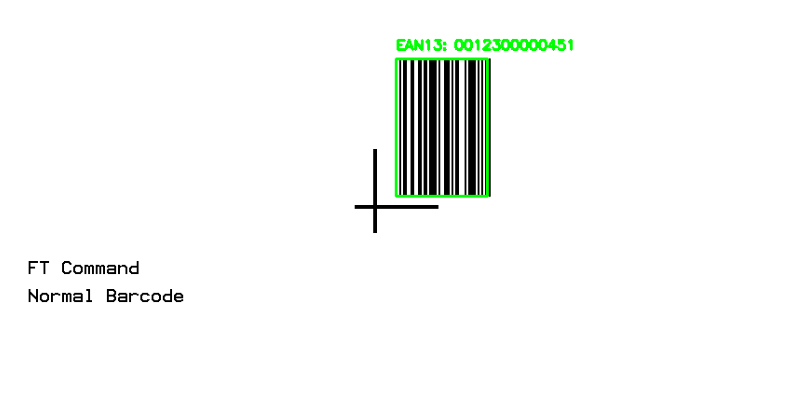

In [ ]:
import cv2
import json
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt

# Paths to image and ground truth JSON
image_path = '/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/ZPL Images/121.bmp'
json_path = '/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/output/121_detections.json'

# Load ground truth data from JSON file
def load_ground_truth(json_path):
    with open(json_path, 'r') as file:
        ground_truth_data = json.load(file)
    return ground_truth_data

# IoU calculation
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Evaluate decoding accuracy
def evaluate_decoding_accuracy(predictions, ground_truth, iou_threshold=0.5):
    correct_decodes = 0
    total_barcodes = sum(1 for gt in ground_truth if gt['class'] == "Barcode")

    for gt in ground_truth:
        gt_bbox = gt['bbox']
        gt_class = gt['class']
        if gt_class != "Barcode":
            continue

        matched = False
        for pred in predictions:
            pred_bbox = pred['bbox']
            pred_type = pred['type']
            iou = calculate_iou(gt_bbox, pred_bbox)
            if iou >= iou_threshold and pred_type == "Barcode":
                matched = True
                correct_decodes += 1
                break

    decoding_accuracy = correct_decodes / total_barcodes if total_barcodes > 0 else 0
    return decoding_accuracy

# Load the image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Load ground truth data
ground_truth_data = load_ground_truth(json_path)

# Detect barcodes in the image
predictions = []
barcodes = decode(image)
barcode_type_counts = {}

for barcode in barcodes:
    # Extract bounding box and barcode details
    x, y, w, h = barcode.rect.left, barcode.rect.top, barcode.rect.width, barcode.rect.height
    bbox = [x, y, w, h]
    decoded_data = barcode.data.decode('utf-8')
    barcode_type = barcode.type

    # Add to predictions list
    predictions.append({"bbox": bbox, "data": decoded_data, "type": "Barcode", "barcode_type": barcode_type})

    # Update barcode type counts
    barcode_type_counts[barcode_type] = barcode_type_counts.get(barcode_type, 0) + 1

    # Draw bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    text = f"{barcode_type}: {decoded_data}"
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Evaluate decoding accuracy
decoding_accuracy = evaluate_decoding_accuracy(predictions, ground_truth_data)
print(f"Decoding Accuracy: {decoding_accuracy * 100:.2f}%")

# Print barcode type counts
print("Detected Barcode Types:")
for barcode_type, count in barcode_type_counts.items():
    print(f"  {barcode_type}: {count}")

# Display predictions and ground truth
print("Predictions:", predictions)
print("Ground Truth:", ground_truth_data)

# Visualize the image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

## Save Output in txt.files

In [ ]:
import cv2
import json
from pyzbar.pyzbar import decode
import os

# Base directories for images and JSON files
image_dir = '/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/ZPL Images'
json_dir = '/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/output'

# Function to crop a region from the image based on bbox
def crop_region(image, bbox):
    height, width = image.shape[:2]
    x, y, w, h = bbox

    # Ensure bbox values are within the image dimensions
    x = max(0, min(x, width - 1))
    y = max(0, min(y, height - 1))
    w = max(0, min(w, width - x))
    h = max(0, min(h, height - y))

    if w == 0 or h == 0:  # Check if the region has valid dimensions
        return None
    return image[y:y+h, x:x+w]

# Analyze text to determine font size, type, and pixel area
def analyze_text(image):
    if image is None:  # Handle empty image
        return "Unknown", 0, 0

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    num_pixels = cv2.countNonZero(binary)

    # Placeholder for font detection (requires OCR libraries like Tesseract for better results)
    font_size = image.shape[0]  # Height of the cropped region as an estimate of font size
    font_type = "Unknown"  # Placeholder for font type
    return font_type, font_size, num_pixels

# Initialize summary variables
summary = {
    "barcode_count": 0,
    "text_count": 0,
    "figure_count": 0,
    "barcode_types": {},
    "total_font_size": 0,
    "total_pixel_count": 0,
    "images_processed": 0
}

# Process JSON files and find matching images
json_files = sorted([f for f in os.listdir(json_dir) if f.endswith('.json')])

for json_file in json_files:
    # Extract the number from the JSON file name (e.g., "5" from "5_detections.json")
    json_number = json_file.split('_')[0]
    image_file = f"{json_number}.bmp"
    image_path = os.path.join(image_dir, image_file)
    json_path = os.path.join(json_dir, json_file)

    # Check if the corresponding image exists
    if not os.path.exists(image_path):
        print(f"Image not found for JSON file: {json_file}")
        continue

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Load ground truth data
    with open(json_path, 'r') as file:
        ground_truth_data = json.load(file)

    print(f"Processing Image: {image_file}")
    summary["images_processed"] += 1

    # Process each ground truth entry
    for gt in ground_truth_data:
        bbox = gt['bbox']
        cls = gt['class']

        # Crop the region based on the bounding box
        cropped_region = crop_region(image, bbox)
        if cropped_region is None:
            print(f"Invalid bounding box: {bbox} in {cls}")
            continue

        if cls == "Barcode":
            # Decode the barcode
            decoded_barcodes = decode(cropped_region)
            for barcode in decoded_barcodes:
                barcode_type = barcode.type
                barcode_data = barcode.data.decode('utf-8')
                barcode_size = (bbox[2], bbox[3])  # Width and height from ground truth bbox
                print(f"  Barcode: Type={barcode_type}, Data={barcode_data}, Size={barcode_size}")

                # Update summary
                summary["barcode_count"] += 1
                summary["barcode_types"][barcode_type] = summary["barcode_types"].get(barcode_type, 0) + 1

        elif cls == "Text":
            # Analyze text for font type, font size, and pixel area
            font_type, font_size, pixel_count = analyze_text(cropped_region)
            print(f"  Text: Font Type={font_type}, Font Size={font_size}, Pixel Count={pixel_count}")

            # Update summary
            summary["text_count"] += 1
            summary["total_font_size"] += font_size
            summary["total_pixel_count"] += pixel_count

        elif cls == "Figure":
            # Handle figure if necessary
            print(f"  Figure: Bounding Box={bbox}")

            # Update summary
            summary["figure_count"] += 1

# Final Summary
average_font_size = summary["total_font_size"] / summary["text_count"] if summary["text_count"] > 0 else 0
average_pixel_count = summary["total_pixel_count"] / summary["text_count"] if summary["text_count"] > 0 else 0
average_barcodes_per_image = summary["barcode_count"] / summary["images_processed"] if summary["images_processed"] > 0 else 0

print("\nSummary:")
print(f"  Total Images Processed: {summary['images_processed']}")
print(f"  Total Barcodes Detected: {summary['barcode_count']}")
print(f"  Total Text Regions Detected: {summary['text_count']}")
print(f"  Total Figures Detected: {summary['figure_count']}")
print(f"  Average Barcodes per Image: {average_barcodes_per_image:.2f}")
print(f"  Average Font Size: {average_font_size:.2f}")
print(f"  Average Text Pixel Count: {average_pixel_count:.2f}")
print(f"  Barcode Types Breakdown:")
for barcode_type, count in summary["barcode_types"].items():
    print(f"    {barcode_type}: {count}")


Processing Image: 1061.bmp
  Text: Font Type=Unknown, Font Size=35, Pixel Count=10166
Processing Image: 1077.bmp
Processing Image: 1081.bmp
  Text: Font Type=Unknown, Font Size=36, Pixel Count=10611
Processing Image: 1102.bmp
Processing Image: 1108.bmp
  Text: Font Type=Unknown, Font Size=30, Pixel Count=6847
Processing Image: 1176.bmp
  Barcode: Type=EAN8, Data=01234565, Size=(149, 108)
  Text: Font Type=Unknown, Font Size=33, Pixel Count=9200
Processing Image: 1186.bmp
  Barcode: Type=EAN8, Data=01234565, Size=(152, 105)
Processing Image: 1212.bmp
  Barcode: Type=EAN13, Data=0123456789128, Size=(227, 106)
  Text: Font Type=Unknown, Font Size=31, Pixel Count=6938
Processing Image: 1217.bmp
  Barcode: Type=EAN13, Data=0123456789128, Size=(224, 106)
Processing Image: 121.bmp
  Barcode: Type=EAN13, Data=0012300000451, Size=(118, 166)
  Text: Font Type=Unknown, Font Size=52, Pixel Count=8112
Processing Image: 1225.bmp
  Barcode: Type=EAN13, Data=0123456789128, Size=(225, 105)
  Text: Font

In [ ]:
import cv2
import json
from pyzbar.pyzbar import decode
import os

# Base directories for images and JSON files
image_dir = '/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/ZPL Images'
json_dir = '/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/output'
output_dir = './output_files'

# Create output folder if not exists
os.makedirs(output_dir, exist_ok=True)

# Function to crop a region from the image based on bbox
def crop_region(image, bbox):
    height, width = image.shape[:2]
    x, y, w, h = bbox

    # Ensure bbox values are within the image dimensions
    x = max(0, min(x, width - 1))
    y = max(0, min(y, height - 1))
    w = max(0, min(w, width - x))
    h = max(0, min(h, height - y))

    if w == 0 or h == 0:  # Check if the region has valid dimensions
        return None
    return image[y:y+h, x:x+w]

# Analyze text to determine font size, type, and pixel area
def analyze_text(image):
    if image is None:  # Handle empty image
        return "Unknown", 0, 0

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    num_pixels = cv2.countNonZero(binary)

    # Placeholder for font detection (requires OCR libraries like Tesseract for better results)
    font_size = image.shape[0]  # Height of the cropped region as an estimate of font size
    font_type = "Unknown"  # Placeholder for font type
    return font_type, font_size, num_pixels

# Initialize summary variables
summary = {
    "barcode_count": 0,
    "text_count": 0,
    "figure_count": 0,
    "barcode_types": {},
    "total_font_size": 0,
    "total_pixel_count": 0,
    "images_processed": 0
}

# Process JSON files and find matching images
json_files = sorted([f for f in os.listdir(json_dir) if f.endswith('.json')])

for json_file in json_files:
    # Extract the number from the JSON file name (e.g., "5" from "5_detections.json")
    json_number = json_file.split('_')[0]
    image_file = f"{json_number}.bmp"
    image_path = os.path.join(image_dir, image_file)
    json_path = os.path.join(json_dir, json_file)

    # Check if the corresponding image exists
    if not os.path.exists(image_path):
        print(f"Image not found for JSON file: {json_file}")
        continue

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Load ground truth data
    with open(json_path, 'r') as file:
        ground_truth_data = json.load(file)

    # Output text file for each image
    output_file_path = os.path.join(output_dir, f"{json_number}.txt")
    with open(output_file_path, 'w') as output_file:
        output_file.write(f"Processing Image: {image_file}\n")
        summary["images_processed"] += 1

        # Process each ground truth entry
        for gt in ground_truth_data:
            bbox = gt['bbox']
            cls = gt['class']

            # Crop the region based on the bounding box
            cropped_region = crop_region(image, bbox)
            if cropped_region is None:
                output_file.write(f"Invalid bounding box: {bbox} in {cls}\n")
                continue

            if cls == "Barcode":
                # Decode the barcode
                decoded_barcodes = decode(cropped_region)
                for barcode in decoded_barcodes:
                    barcode_type = barcode.type
                    barcode_data = barcode.data.decode('utf-8')
                    barcode_size = (bbox[2], bbox[3])  # Width and height from ground truth bbox
                    output_file.write(f"  Barcode: Type={barcode_type}, Data={barcode_data}, Size={barcode_size}\n")

                    # Update summary
                    summary["barcode_count"] += 1
                    summary["barcode_types"][barcode_type] = summary["barcode_types"].get(barcode_type, 0) + 1

            elif cls == "Text":
                # Analyze text for font type, font size, and pixel area
                font_type, font_size, pixel_count = analyze_text(cropped_region)
                output_file.write(f"  Text: Font Type={font_type}, Font Size={font_size}, Pixel Count={pixel_count}\n")

                # Update summary
                summary["text_count"] += 1
                summary["total_font_size"] += font_size
                summary["total_pixel_count"] += pixel_count

            elif cls == "Figure":
                # Handle figure if necessary
                output_file.write(f"  Figure: Bounding Box={bbox}\n")

                # Update summary
                summary["figure_count"] += 1

# Final Summary File
summary_file_path = os.path.join(output_dir, "summary.txt")
with open(summary_file_path, 'w') as summary_file:
    average_font_size = summary["total_font_size"] / summary["text_count"] if summary["text_count"] > 0 else 0
    average_pixel_count = summary["total_pixel_count"] / summary["text_count"] if summary["text_count"] > 0 else 0
    average_barcodes_per_image = summary["barcode_count"] / summary["images_processed"] if summary["images_processed"] > 0 else 0

    summary_file.write("Summary:\n")
    summary_file.write(f"  Total Images Processed: {summary['images_processed']}\n")
    summary_file.write(f"  Total Barcodes Detected: {summary['barcode_count']}\n")
    summary_file.write(f"  Total Text Regions Detected: {summary['text_count']}\n")
    summary_file.write(f"  Total Figures Detected: {summary['figure_count']}\n")
    summary_file.write(f"  Average Barcodes per Image: {average_barcodes_per_image:.2f}\n")
    summary_file.write(f"  Average Font Size: {average_font_size:.2f}\n")
    summary_file.write(f"  Average Text Pixel Count: {average_pixel_count:.2f}\n")
    summary_file.write("  Barcode Types Breakdown:\n")
    for barcode_type, count in summary["barcode_types"].items():
        summary_file.write(f"    {barcode_type}: {count}\n")


In [ ]:
import cv2
import json
from pyzbar.pyzbar import decode
import os

# Base directories for images and JSON files
image_dir = '/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/ZPL Images'
json_dir = '/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/output'
output_dir = './output_files'

# Create output folder if not exists
os.makedirs(output_dir, exist_ok=True)

# Function to crop a region from the image based on bbox
def crop_region(image, bbox):
    height, width = image.shape[:2]
    x, y, w, h = bbox

    # Ensure bbox values are within the image dimensions
    x = max(0, min(x, width - 1))
    y = max(0, min(y, height - 1))
    w = max(0, min(w, width - x))
    h = max(0, min(h, height - y))

    if w == 0 or h == 0:  # Check if the region has valid dimensions
        return None
    return image[y:y+h, x:x+w]

# Analyze text to determine font size, type, and pixel area
def analyze_text(image):
    if image is None:  # Handle empty image
        return "Unknown", 0, 0

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    num_pixels = cv2.countNonZero(binary)

    # Placeholder for font detection (requires OCR libraries like Tesseract for better results)
    font_size = image.shape[0]  # Height of the cropped region as an estimate of font size
    font_type = "Unknown"  # Placeholder for font type
    return font_type, font_size, num_pixels

# Initialize summary variables
summary = {
    "barcode_count": 0,
    "text_count": 0,
    "figure_count": 0,
    "barcode_types": {},
    "total_font_size": 0,
    "total_pixel_count": 0,
    "images_processed": 0
}

# Process JSON files and find matching images
json_files = sorted([f for f in os.listdir(json_dir) if f.endswith('.json')])

for json_file in json_files:
    # Extract the number from the JSON file name (e.g., "5" from "5_detections.json")
    json_number = json_file.split('_')[0]
    image_file = f"{json_number}.bmp"
    image_path = os.path.join(image_dir, image_file)
    json_path = os.path.join(json_dir, json_file)

    # Check if the corresponding image exists
    if not os.path.exists(image_path):
        print(f"Image not found for JSON file: {json_file}")
        continue

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Load ground truth data
    with open(json_path, 'r') as file:
        ground_truth_data = json.load(file)

    # Output text file for each image
    output_file_path = os.path.join(output_dir, f"{json_number}.txt")
    with open(output_file_path, 'w') as output_file:
        output_file.write(f"Processing Image: {image_file}\n")
        summary["images_processed"] += 1

        barcode_count_in_image = 0

        # Process each ground truth entry
        for gt in ground_truth_data:
            bbox = gt['bbox']
            cls = gt['class']

            # Crop the region based on the bounding box
            cropped_region = crop_region(image, bbox)
            if cropped_region is None:
                output_file.write(f"Invalid bounding box: {bbox} in {cls}\n")
                continue

            if cls == "Barcode":
                # Decode the barcode
                decoded_barcodes = decode(cropped_region)
                if decoded_barcodes:
                    for barcode in decoded_barcodes:
                        barcode_type = barcode.type
                        barcode_data = barcode.data.decode('utf-8')
                        barcode_size = (bbox[2], bbox[3])  # Width and height from ground truth bbox
                        output_file.write(f"  Barcode: Type={barcode_type}, Data={barcode_data}, Size={barcode_size}\n")

                        # Update summary
                        summary["barcode_count"] += 1
                        summary["barcode_types"][barcode_type] = summary["barcode_types"].get(barcode_type, 0) + 1
                        barcode_count_in_image += 1
                else:
                    output_file.write(f"  Barcode: Type=Unknown, Data=Unknown, Bounding Box={bbox}\n")
                    summary["barcode_count"] += 1
                    summary["barcode_types"]["Unknown"] = summary["barcode_types"].get("Unknown", 0) + 1
                    barcode_count_in_image += 1

            elif cls == "Text":
                # Analyze text for font type, font size, and pixel area
                font_type, font_size, pixel_count = analyze_text(cropped_region)
                output_file.write(f"  Text: Font Type={font_type}, Font Size={font_size}, Pixel Count={pixel_count}\n")

                # Update summary
                summary["text_count"] += 1
                summary["total_font_size"] += font_size
                summary["total_pixel_count"] += pixel_count

            elif cls == "Figure":
                # Handle figure if necessary
                output_file.write(f"  Figure: Bounding Box={bbox}\n")

                # Update summary
                summary["figure_count"] += 1

        output_file.write(f"\nTotal Barcodes in Image: {barcode_count_in_image}\n")

# Final Summary File
summary_file_path = os.path.join(output_dir, "summary.txt")
with open(summary_file_path, 'w') as summary_file:
    average_font_size = summary["total_font_size"] / summary["text_count"] if summary["text_count"] > 0 else 0
    average_pixel_count = summary["total_pixel_count"] / summary["text_count"] if summary["text_count"] > 0 else 0
    average_barcodes_per_image = summary["barcode_count"] / summary["images_processed"] if summary["images_processed"] > 0 else 0

    summary_file.write("Summary:\n")
    summary_file.write(f"  Total Images Processed: {summary['images_processed']}\n")
    summary_file.write(f"  Total Barcodes Detected: {summary['barcode_count']}\n")
    summary_file.write(f"  Total Text Regions Detected: {summary['text_count']}\n")
    summary_file.write(f"  Total Figures Detected: {summary['figure_count']}\n")
    summary_file.write(f"  Average Barcodes per Image: {average_barcodes_per_image:.2f}\n")
    summary_file.write(f"  Average Font Size: {average_font_size:.2f}\n")
    summary_file.write(f"  Average Text Pixel Count: {average_pixel_count:.2f}\n")
    summary_file.write("  Barcode Types Breakdown:\n")
    for barcode_type, count in summary["barcode_types"].items():
        summary_file.write(f"    {barcode_type}: {count}\n")


In [ ]:
!apt-get update
!apt-get install -y libzbar-dev
!pip install pyzbar


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,454 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,506 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packa

In [ ]:
import shutil

# Path to your output folder
output_dir = "output_files"

# Path to save in Google Drive
drive_output_path = "/content/drive/MyDrive/Colab_Output/barcode_output2"

# Copy folder to Google Drive
shutil.copytree(output_dir, drive_output_path)

print(f"Output folder saved to: {drive_output_path}")


Output folder saved to: /content/drive/MyDrive/Colab_Output/barcode_output2
